In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/data.xlsx")

In [4]:
df.head()

,Unnamed: 0,0
0,0,3.896195
1,1,5.865766
2,2,5.860887
3,3,4.660614
4,4,5.263595


(array([ 1.,  1.,  5., 12., 10., 18., 16.,  8.,  5.,  4.]),
 array([2.29193477, 2.77510498, 3.25827519, 3.74144541, 4.22461562,
        4.70778584, 5.19095605, 5.67412627, 6.15729648, 6.64046669,
        7.12363691]),
 <a list of 10 Patch objects>)

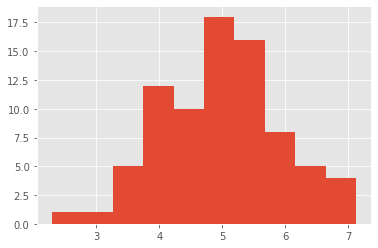

In [5]:
plt.hist(df[0])

In [6]:
stan_model = """
data {
    int N;
    real Y[N];
}

parameters {
    real mu;
    real<lower=0> sigma;
}

model {
    for (i in 1:N){
        Y[i] ~ normal(mu, sigma);
    }
}
"""

In [7]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ebb246e7e6b1b464d832f5439ce0358 NOW.


In [8]:
stan_data = {"N":df.shape[0], "Y":df[0]}

In [9]:
fit = sm.sampling(data=stan_data, iter=2000, chains=3, warmup=500, seed=123)

In [10]:
fit

Inference for Stan model: anon_model_7ebb246e7e6b1b464d832f5439ce0358.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      4.98  1.8e-3   0.11   4.76   4.91   4.98   5.05   5.19   3601    1.0
sigma   0.97  1.4e-3   0.08   0.83   0.92   0.97   1.02   1.14   3220    1.0
lp__  -37.06    0.02   1.01 -39.68 -37.45 -36.75 -36.35  -36.1   2071    1.0

Samples were drawn using NUTS at Wed Apr  7 07:15:10 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

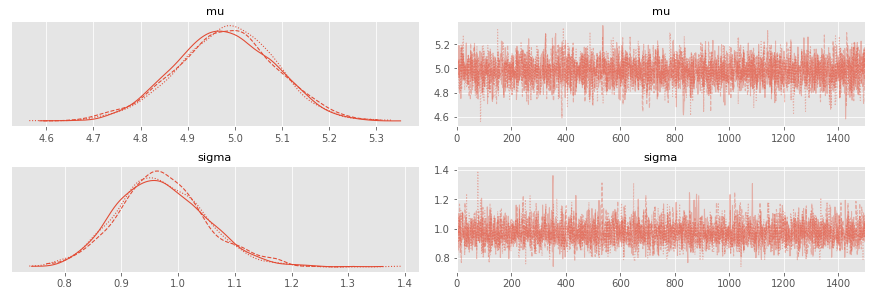

In [13]:
#fig = fit.plot()
import arviz
fig = arviz.plot_trace(fit)

In [14]:
from scipy.stats import mstats

In [15]:
df = pd.read_excel("./data/real_estate1.xlsx")

In [18]:
stan_model = """
data {
    int N;
    real X[N];
    real Y[N];
    int N_s;
    real X_s[N_s];
}

parameters {
    real a;
    real b;
    real<lower=0> sigma;
}

model {
    for (i in 1:N){
        Y[i] ~ normal(a * X[i] + b, sigma);
    }
}

generated quantities {
    real Y_s[N_s];
    for (i in 1:N_s){
        Y_s[i] = normal_rng(a * X_s[i] + b, sigma);
    }
}

"""

In [19]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_92571a518b03e31322d02da03672fe80 NOW.


In [25]:
import numpy as np
X_s = np.arange(40, 90, 1)
N_s = X_s.shape[0]
stan_data = {"N":df.shape[0], "X":df["space"], "Y":df["value"], "N_s":N_s, "X_s":X_s}

In [26]:
fit = sm.sampling(data=stan_data, iter=2000, warmup=500, chains=3, seed=123)

In [38]:
ms_a = fit.extract("a")["a"]
ms_a

array([ 76.41266253,  93.94065493,  80.63040866, ...,  95.98200868,
        53.71508784, 105.92215028])

In [39]:
ms_b = fit.extract("b")["b"]

In [40]:
df_b = pd.DataFrame([])
for i in range(40, 90, 1):
    df_b[i] = ms_a * i + ms_b

In [41]:
df_b

,40,41,42,43,44,45,46,47,48,49,...,80,81,82,83,84,85,86,87,88,89
0,2494.951533,2571.364196,2647.776858,2724.189521,2800.602183,2877.014846,2953.427508,3029.840171,3106.252833,3182.665496,...,5551.458034,5627.870697,5704.283359,5780.696022,5857.108684,5933.521347,6009.934009,6086.346672,6162.759335,6239.171997
1,1847.759777,1941.700432,2035.641086,2129.581741,2223.522396,2317.463051,2411.403706,2505.344361,2599.285016,2693.225671,...,5605.385974,5699.326629,5793.267284,5887.207939,5981.148594,6075.089249,6169.029904,6262.970558,6356.911213,6450.851868
2,2150.256798,2230.887207,2311.517615,2392.148024,2472.778432,2553.408841,2634.039250,2714.669658,2795.300067,2875.930476,...,5375.473144,5456.103553,5536.733962,5617.364370,5697.994779,5778.625188,5859.255596,5939.886005,6020.516414,6101.146822
3,2362.582375,2437.868728,2513.155081,2588.441433,2663.727786,2739.014139,2814.300491,2889.586844,2964.873197,3040.159549,...,5374.036482,5449.322835,5524.609187,5599.895540,5675.181893,5750.468245,5825.754598,5901.040951,5976.327303,6051.613656
4,2502.128603,2573.937127,2645.745652,2717.554177,2789.362701,2861.171226,2932.979750,3004.788275,3076.596800,3148.405324,...,5374.469586,5446.278110,5518.086635,5589.895160,5661.703684,5733.512209,5805.320733,5877.129258,5948.937782,6020.746307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,2683.472453,2751.343904,2819.215354,2887.086805,2954.958256,3022.829707,3090.701157,3158.572608,3226.444059,3294.315510,...,5398.330483,5466.201934,5534.073385,5601.944835,5669.816286,5737.687737,5805.559188,5873.430638,5941.302089,6009.173540
4496,2540.431482,2618.357792,2696.284102,2774.210413,2852.136723,2930.063033,3007.989343,3085.915653,3163.841964,3241.768274,...,5657.483891,5735.410201,5813.336511,5891.262821,5969.189131,6047.115442,6125.041752,6202.968062,6280.894372,6358.820683
4497,2130.006216,2225.988225,2321.970234,2417.952242,2513.934251,2609.916260,2705.898268,2801.880277,2897.862286,2993.844294,...,5969.286563,6065.268572,6161.250581,6257.232589,6353.214598,6449.196607,6545.178615,6641.160624,6737.142633,6833.124641
4498,3116.436390,3170.151478,3223.866565,3277.581653,3331.296741,3385.011829,3438.726917,3492.442005,3546.157092,3599.872180,...,5265.039903,5318.754991,5372.470079,5426.185167,5479.900255,5533.615342,5587.330430,5641.045518,5694.760606,5748.475694


In [42]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

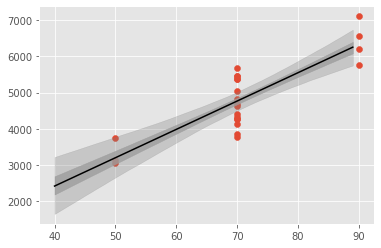

In [60]:
plt.scatter(df["space"], df["value"])
plt.fill_between(X_s, low_y50, high_y50, alpha=0.8, color="darkgray")
plt.fill_between(X_s, low_y95, high_y95, alpha=0.3, color="gray")
a = 78.3
b = -713.7
y=a*X_s+b
plt.plot(X_s, y, color="k")